In [ ]:
%pip install torchsummary torchshow pytorch-ignite==0.5.0.dev20230611

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import numpy as np

from PIL import Image
from torchvision import transforms, datasets
import torchvision
import torchshow as ts

import io
import requests
import PIL

import torch

from collections import OrderedDict

from torch import nn, optim, Tensor

from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.utils import *
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *

from torch.utils.data import DataLoader

import torch.nn.functional as F
import torch.optim as optim
import torchshow as ts
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, random_split

from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Загружаем датасет

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Определим трансформации
cifar_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
    ])

# Загрузим dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=cifar_transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

<Figure size 1500x400 with 0 Axes>

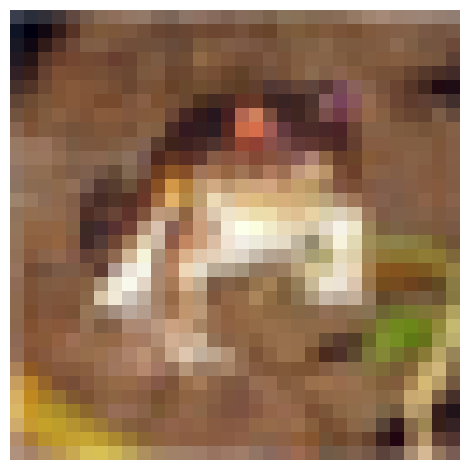

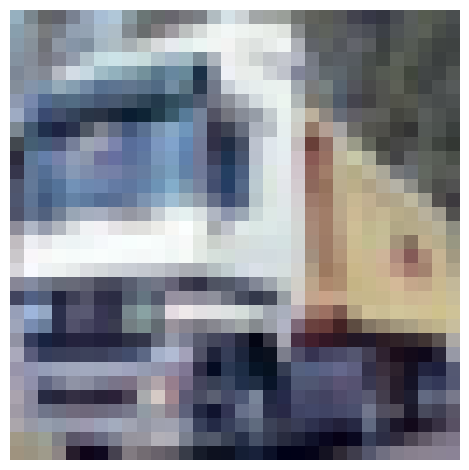

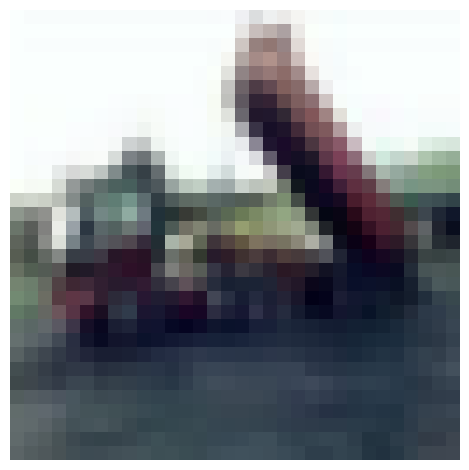

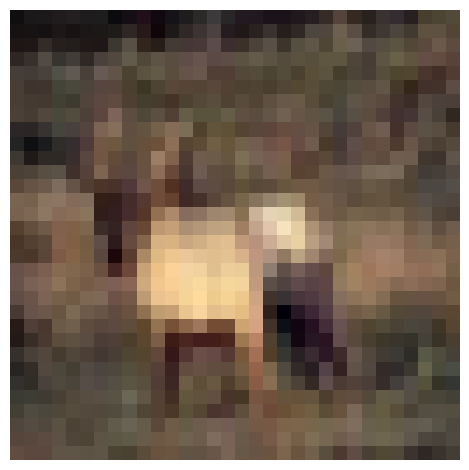

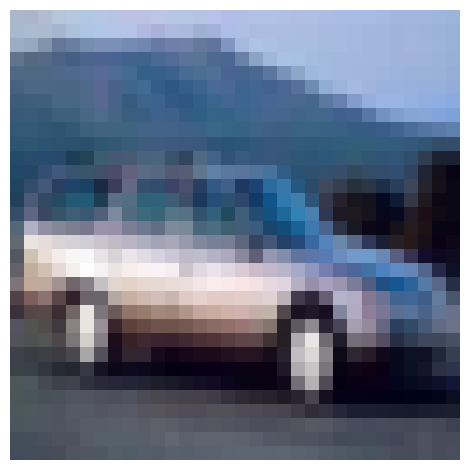

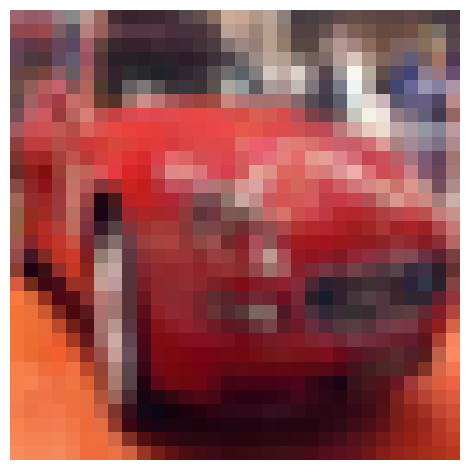

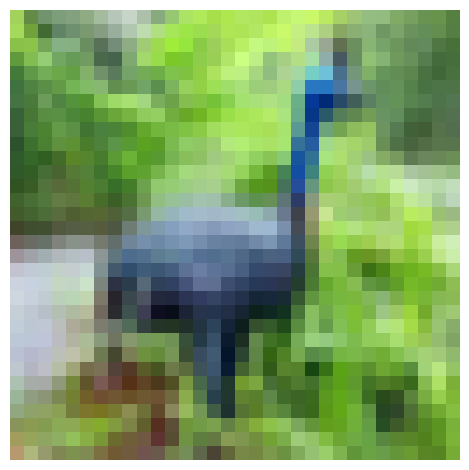

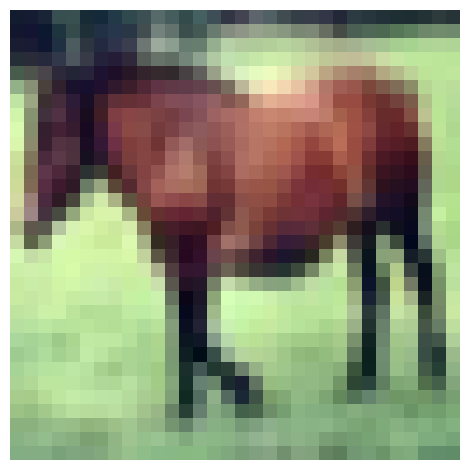

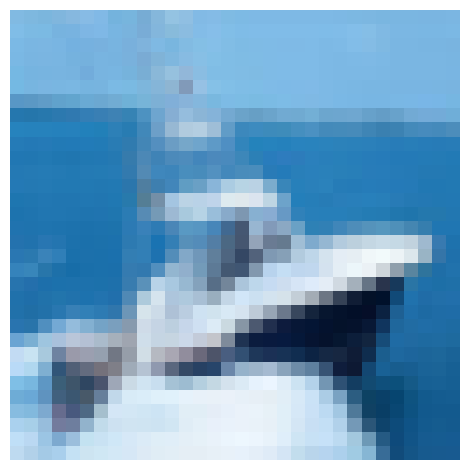

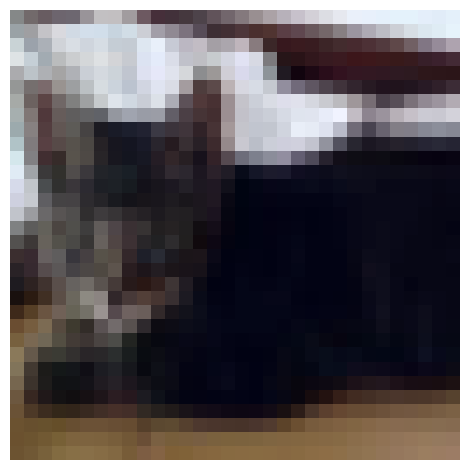

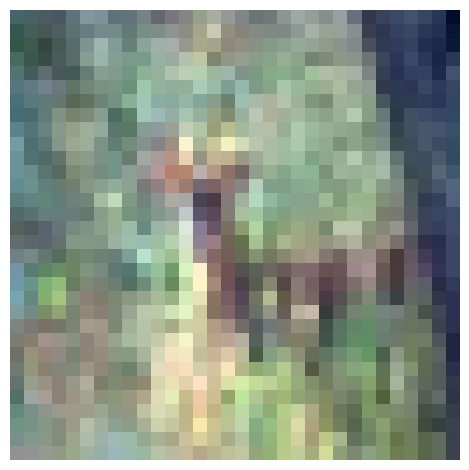

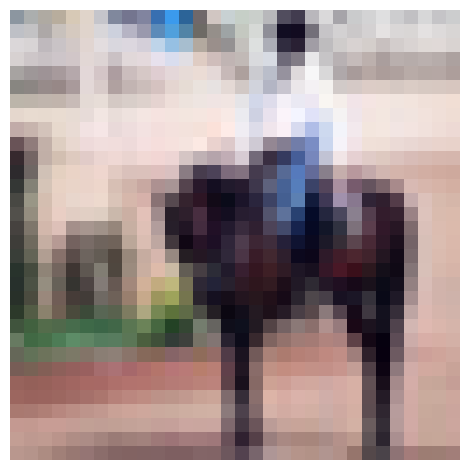

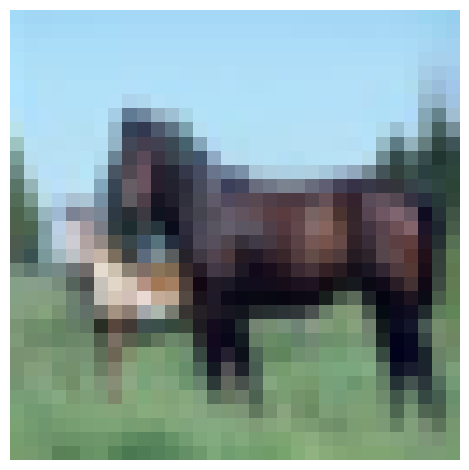

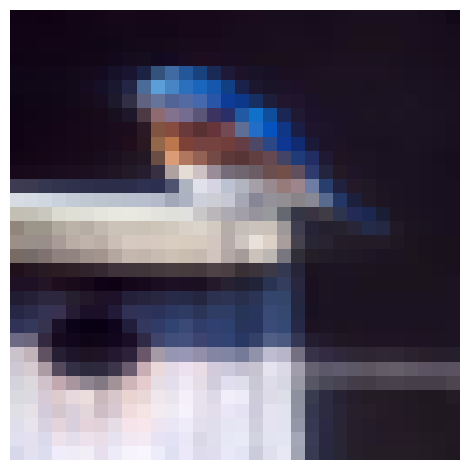

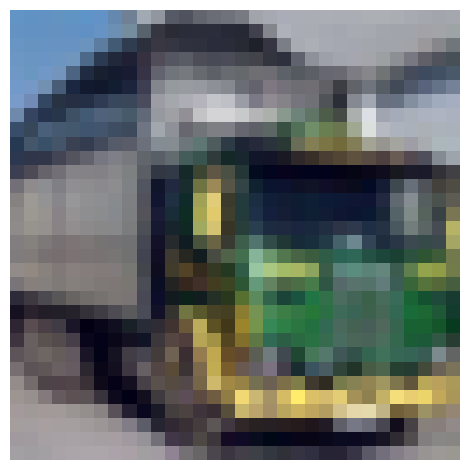

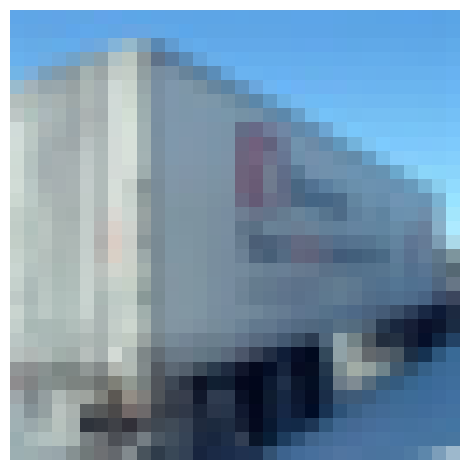

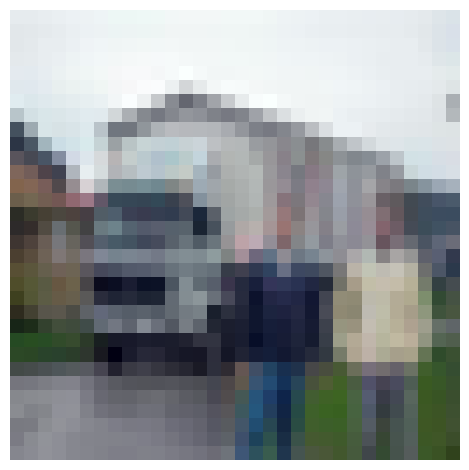

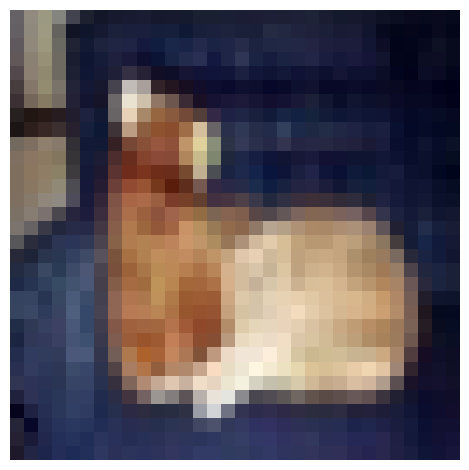

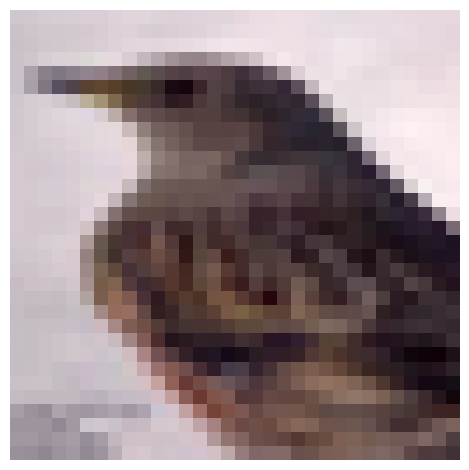

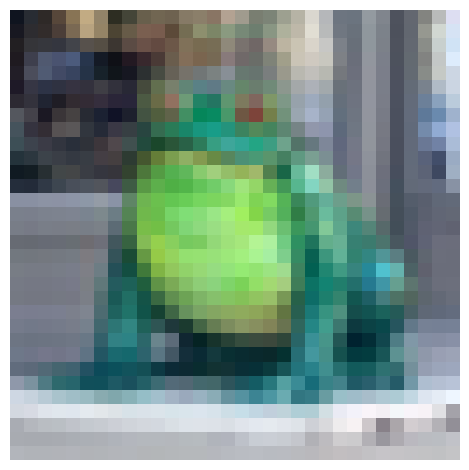

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))

for i in range(20):
    # plt.subplot(2, 10, i + 1)
    # plt.imshow(train_dataset[i][0].permute(1, 2, 0)
    #           )
    img = train_dataset[i][0]
    ts.show(img)
    # img.shape
    # plt.xticks([])
    # plt.yticks([])
    # plt.title(classes[train_dataset[i][1]])

# plt.show()

In [ ]:
img_shape = train_dataset[0][0].shape
img_shape

torch.Size([3, 32, 32])

In [ ]:
class SimpleVariationalAutoEncoder(nn.Module):
    def __init__(self, latent_dim, img_shape=img_shape):
        super().__init__()

        self.encoder_common = nn.Sequential(
            nn.Flatten(),
            nn.Linear(np.prod(img_shape), 512),
            nn.LeakyReLU(),
            nn.Linear(512, 512),
            nn.LeakyReLU()
        )
        self.encoder_m = nn.Linear(512, latent_dim)
        self.encoder_s = nn.Linear(512, latent_dim)

        self.N = torch.distributions.Normal(0, 1)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 512),
            nn.LeakyReLU(),
            nn.Linear(512, np.prod(img_shape)),
            nn.Tanh(),
            nn.Unflatten(1, img_shape)
        )

    def encode(self, x):
        x = self.encoder_common(x)
        m = self.encoder_m(x)
        s = torch.exp(self.encoder_s(x))
        return m + s * self.N.sample(m.shape)

    def forward(self, x):
        x = self.encoder_common(x)
        m = self.encoder_m(x)
        log_s = self.encoder_s(x)
        s = torch.exp(log_s)
        z = m + s * torch.randn_like(m)
        y = self.decoder(z)
        return y, m, log_s

    def process(self, x):
        return self(x)

Далее функция кастомного лосса в виде MSE и KL дивергенции с беттой (экспериментировал с ее регуляризацией)

In [ ]:
import torch
import torch.nn.functional as F

# Кастомный лосс для VAE
def vae_loss(x, x_reconstructed, mu, log_var, beta=0.1):
    # Reconstruction loss
    recon_loss = F.mse_loss(x_reconstructed, x, reduction='sum')
    # KL divergence
    kl_loss = 0.5 * torch.sum(mu.pow(2) + log_var.exp() - log_var - 1)
    return recon_loss + beta * kl_loss

Такая же функция, только здесь я определял взрыв градиаента (были одни NaN в тензорах)

In [ ]:
def vae_loss(x, x_reconstructed, mu, log_var, beta=0.1):
    # Проверка входных данных
    assert not torch.isnan(x).any(), "NaN в входных данных"
    assert not torch.isnan(x_reconstructed).any(), "NaN в реконструкции"

    # Стабилизация log_var
    log_var = torch.clamp(log_var, min=-20, max=20)  # Ограничиваем значения

    # Reconstruction loss с защитой
    recon_loss = F.mse_loss(
        x_reconstructed,
        x,
        reduction='sum'
    )

    # Стабильный расчет KL divergence
    kl_element = 0.5 * (mu.pow(2) + log_var.exp() - log_var - 1)
    kl_loss = torch.sum(kl_element)

    # Проверка на NaN перед возвратом
    if torch.isnan(recon_loss) or torch.isnan(kl_loss):
        print("Обнаружены NaN значения!")
        print("log_var min/max:", log_var.min().item(), log_var.max().item())
        print("mu min/max:", mu.min().item(), mu.max().item())
        print("x min/max:", x.min().item(), x.max().item())
        print("x_reconstructed min/max:", x_reconstructed.min().item(), x_reconstructed.max().item())
        raise ValueError("NaN в функции потерь")

    return recon_loss + beta * kl_loss

In [ ]:
from tqdm import tqdm

# одна эпоха обучения
def run_epoch(ae, opt, loss, dataloader, is_train=True):
    ae.train(is_train)
    total_loss = 0.0
    with torch.set_grad_enabled(is_train):
        for x, _ in tqdm(dataloader):
            x = x.to(device)
            output = ae(x)
            total_loss = vae_loss(x, output[0], output[1], output[2]) # Кастомный лосс, по сути передавать сюда loss бесполезно, но я оставил его как апендикс, чтобы функцию не переопределять)
            # total_loss = loss(x, output[0])
            if (is_train):
                opt.zero_grad()
                total_loss.backward()
                opt.step()
            total_loss += total_loss.item()
    return total_loss / len(dataloader.dataset)

In [ ]:
# отрисовка лосса
def plot_loss(loss, title, num_epochs):
    plt.title(title)
    if torch.is_tensor(loss[-1]):
            loss = [l.cpu().detach().numpy() if torch.is_tensor(l) else l for l in loss]
    plt.plot(loss)
    plt.grid()
    plt.xticks(np.arange(num_epochs))

def plot_losses(train, val, num_epochs):
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plot_loss(train, f'Train Loss = {train[-1]}', num_epochs)
    plt.subplot(1, 2, 2)
    plot_loss(val, f'Val Loss = {val[-1]}', num_epochs)
    plt.show()

In [ ]:
# отрисовка изображений - реальных и после автоэнкодера
def show_examples(ae, dataset, size):
    ae.eval()
    with torch.no_grad():
        idxs = np.random.randint(0, len(dataset), size)
        x = torch.stack([dataset[i][0] for i in idxs]).to(device)
        y = ae.process(x)[0].to(device)
        print("Original images")
        ts.show(x, nrows=1, figsize=(12, 2))
        print("Reconstructed")
        ts.show(y, nrows=1, figsize=(12, 2))

In [ ]:
from IPython.display import clear_output

def run_train_loop(ae, opt, loss, train_loader, val_loader, num_epochs, ex_size):
    train_hist = []
    val_hist = []
    for e in range(num_epochs):
        print("Trainin...")
        train_loss = run_epoch(ae, opt, loss, train_loader)

        train_hist.append(train_loss)
        print("Validating...")
        val_loss = run_epoch(ae, opt, loss, val_loader, is_train=False)
        val_hist.append(val_loss)
        clear_output()
        plot_losses(train_hist, val_hist, num_epochs)
        show_examples(ae, val_loader.dataset, ex_size)

In [ ]:
BATCH_SIZE = 256
NUM_EPOCHS = 10
LAT_DIM = 8 # размерность скрытого пространства
EX_SIZE = 8 # число примеров для отрисовки

In [ ]:
svae = SimpleVariationalAutoEncoder(LAT_DIM).to(device)

summary(svae, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]           1,568
       BatchNorm2d-2           [-1, 32, 16, 16]              64
         LeakyReLU-3           [-1, 32, 16, 16]               0
            Conv2d-4             [-1, 64, 8, 8]          32,832
       BatchNorm2d-5             [-1, 64, 8, 8]             128
         LeakyReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 4, 4]         131,200
       BatchNorm2d-8            [-1, 128, 4, 4]             256
         LeakyReLU-9            [-1, 128, 4, 4]               0
          Flatten-10                 [-1, 2048]               0
           Linear-11                    [-1, 8]          16,392
           Linear-12                    [-1, 8]          16,392
           Linear-13                 [-1, 2048]          18,432
        Unflatten-14            [-1, 12

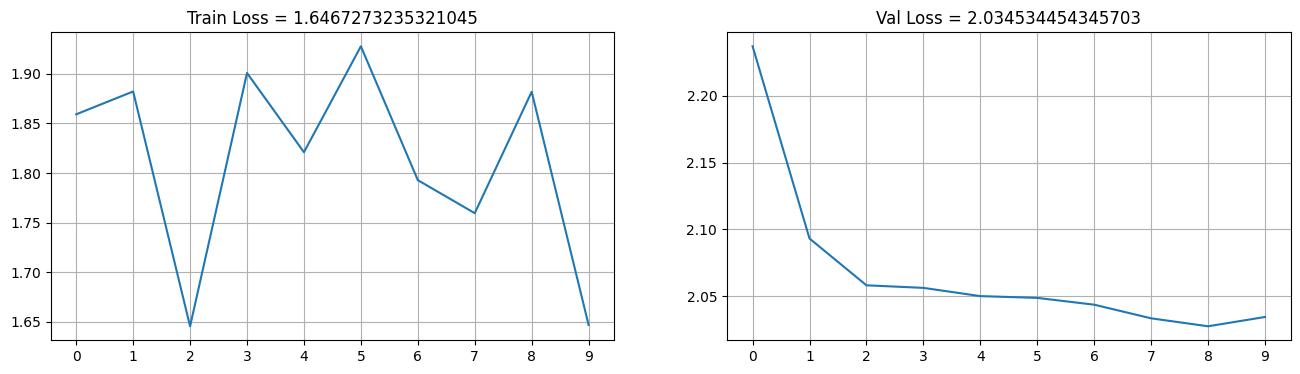

Original images


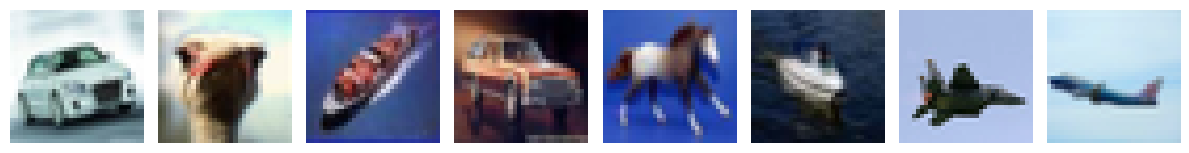

Reconstructed


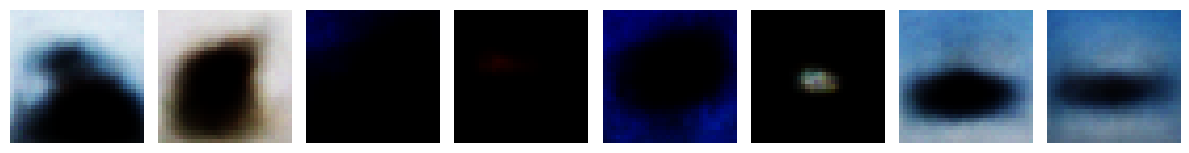

In [ ]:
svae = SimpleVariationalAutoEncoder(LAT_DIM).to(device)

# Создадим DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

svae_opt = optim.Adam(svae.parameters(), lr=1e-3
                      )
svae_loss = nn.MSELoss(reduction='sum')

run_train_loop(svae, svae_opt, svae_loss,
               train_loader, test_loader, NUM_EPOCHS, EX_SIZE)

Получились такие пятна потому что был большой lr у оптимайзера, и слишком маленькое латентное пространство (размерность всего 8)

Далее уже добавил свертки

In [ ]:
class SimpleVariationalAutoEncoder(nn.Module):
    def __init__(self, latent_dim, img_shape=img_shape):
        super().__init__()

        # Энкодер
        self.encoder_common = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),          # [32, 16, 16]
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, 2, 1),         # [64, 8, 8]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),         # [128, 4, 4]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Flatten()                         # [128 * 4 * 4]
        )

        self.encoder_m = nn.Linear(128*4*4, latent_dim)
        self.encoder_s = nn.Linear(128*4*4, latent_dim)

        self.N = torch.distributions.Normal(0, 1)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128*4*4),     # [128 * 4 * 4]
            nn.Unflatten(1, (128, 4, 4)),       # [128, 4, 4]
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # [64, 8, 8]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # [32, 16, 16]
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),     # [3, 32, 32]
            nn.Tanh()
        )

    def encode(self, x):
        x = self.encoder_common(x)
        m = self.encoder_m(x)
        s = torch.exp(self.encoder_s(x))
        return m + s * self.N.sample(m.shape)

    def forward(self, x):
        x = self.encoder_common(x)
        m = self.encoder_m(x)
        log_s = self.encoder_s(x)
        s = torch.exp(log_s)
        z = m + s * torch.randn_like(m)
        y = self.decoder(z)
        return y, m, log_s

    def process(self, x):
        return self(x)

In [ ]:
BATCH_SIZE = 256
NUM_EPOCHS = 30
LAT_DIM = 256 # размерность скрытого пространства
EX_SIZE = 8 # число примеров для отрисовки

In [ ]:
svae = SimpleVariationalAutoEncoder(LAT_DIM).to(device)

summary(svae, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]           1,568
       BatchNorm2d-2           [-1, 32, 16, 16]              64
         LeakyReLU-3           [-1, 32, 16, 16]               0
            Conv2d-4             [-1, 64, 8, 8]          32,832
       BatchNorm2d-5             [-1, 64, 8, 8]             128
         LeakyReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 4, 4]         131,200
       BatchNorm2d-8            [-1, 128, 4, 4]             256
         LeakyReLU-9            [-1, 128, 4, 4]               0
          Flatten-10                 [-1, 2048]               0
           Linear-11                  [-1, 256]         524,544
           Linear-12                  [-1, 256]         524,544
           Linear-13                 [-1, 2048]         526,336
        Unflatten-14            [-1, 12

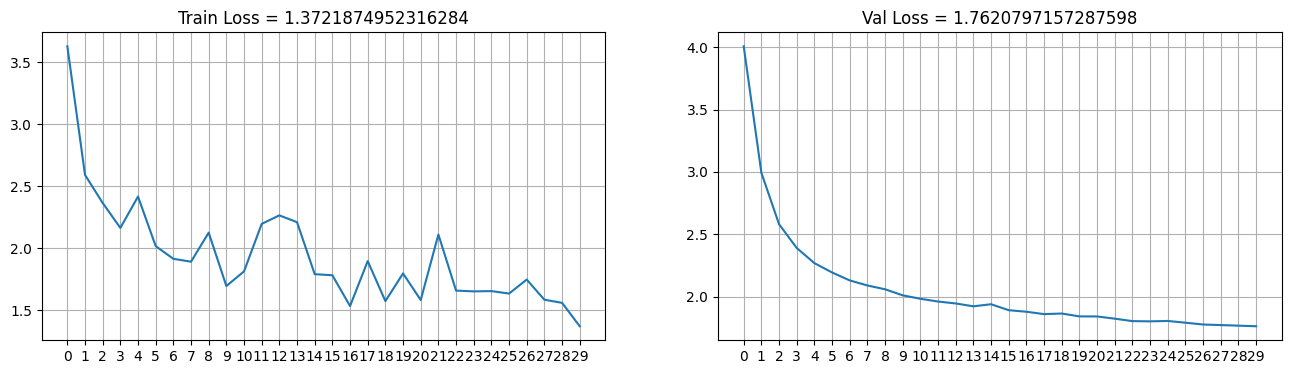

Original images


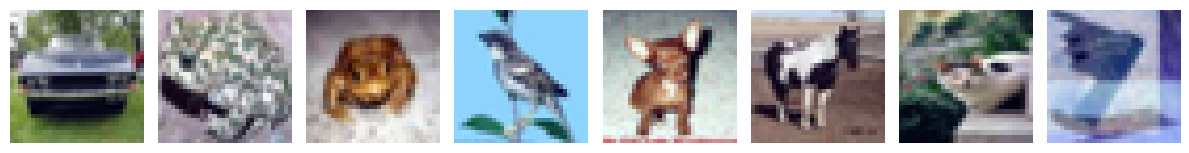

Reconstructed


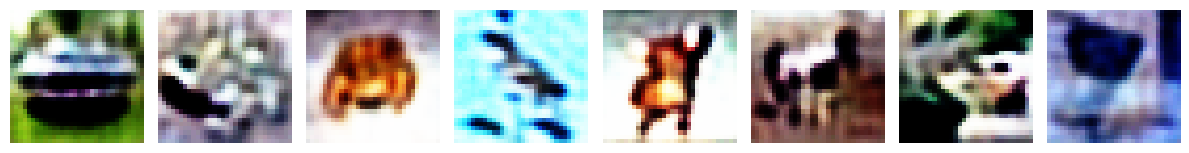

In [ ]:
svae = SimpleVariationalAutoEncoder(LAT_DIM).to(device)

# Создадим DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

svae_opt = optim.Adam(svae.parameters(), lr=1e-4)
svae_loss = nn.MSELoss(reduction='sum')

run_train_loop(svae, svae_opt, svae_loss,
               train_loader, test_loader, NUM_EPOCHS, EX_SIZE)

Как видно картинки уже получились более схожими. Для второй архитектуры со свертками использовал меньший lr=0.0001 и латентное пространство размером 256